Using device: mps

Training WasteClassifier...
Epoch 1: Train Loss: 2.7293, Train Acc: 19.85%, Val Loss: 1.2205, Val Acc: 25.33%
Epoch 2: Train Loss: 1.2562, Train Acc: 27.38%, Val Loss: 1.0495, Val Acc: 26.91%
Epoch 3: Train Loss: 1.0435, Train Acc: 36.14%, Val Loss: 1.0079, Val Acc: 35.09%
Epoch 4: Train Loss: 0.9417, Train Acc: 43.67%, Val Loss: 0.9042, Val Acc: 43.01%
Epoch 5: Train Loss: 0.8329, Train Acc: 48.47%, Val Loss: 1.0478, Val Acc: 43.54%
Epoch 6: Train Loss: 0.7911, Train Acc: 51.81%, Val Loss: 0.9217, Val Acc: 41.95%
Epoch 7: Train Loss: 0.7285, Train Acc: 55.43%, Val Loss: 0.8582, Val Acc: 45.91%
Epoch 8: Train Loss: 0.6290, Train Acc: 58.48%, Val Loss: 0.8466, Val Acc: 48.28%
Epoch 9: Train Loss: 0.5985, Train Acc: 59.28%, Val Loss: 1.0810, Val Acc: 49.60%
Epoch 10: Train Loss: 0.5569, Train Acc: 61.26%, Val Loss: 0.9039, Val Acc: 49.08%
Epoch 11: Train Loss: 0.4147, Train Acc: 65.61%, Val Loss: 0.8521, Val Acc: 52.77%
Epoch 12: Train Loss: 0.4023, Train Acc: 66.69%, 

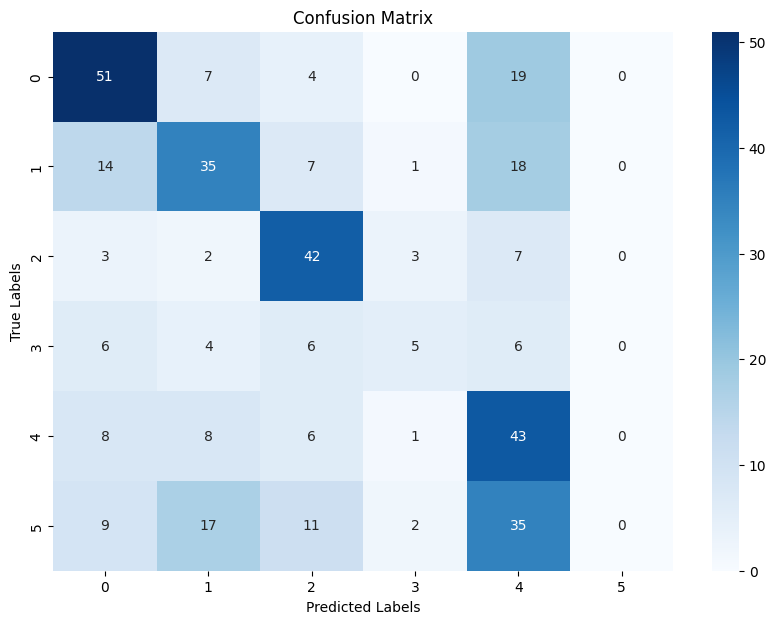


Evaluating Custom ResNet Model...
Test Accuracy: 35.26%


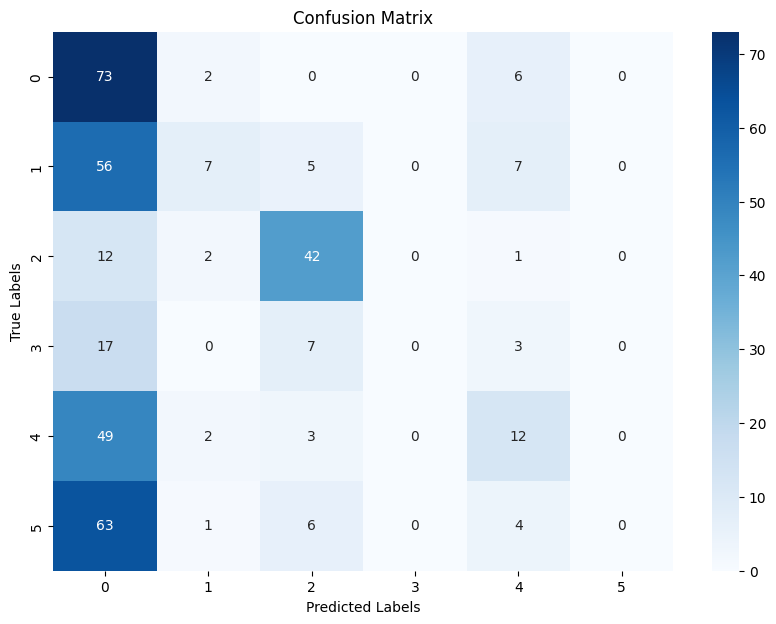

In [2]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Check for device: use MPS if available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset path
dataset_path = '/Users/enxom/Desktop/INM705 CW/dataset1'

# Collect data helper functions
def is_valid_file(file_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return any(file_path.endswith(ext) for ext in valid_extensions)

def collect_data(directory):
    data = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(directory)) if os.path.isdir(os.path.join(directory, cls))}
    for cls, idx in class_to_idx.items():
        class_path = os.path.join(directory, cls)
        for file_path in glob.glob(os.path.join(class_path, '*')):
            if is_valid_file(file_path):
                data.append(file_path)
                labels.append(idx)
    return data, labels, class_to_idx

# Data transformations and dataset preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Custom Dataset Class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load and split dataset
data, labels, class_to_idx = collect_data(dataset_path)
dataset = CustomImageDataset(data, labels, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Compute class weights for imbalanced datasets
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Waste Classifier Model
class WasteClassifier(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 56 * 56, 1024),
            nn.ReLU(),
            nn.Linear(1024, len(class_to_idx))
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Custom ResNet Model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# Instantiate both models
model1 = WasteClassifier(num_classes=len(class_to_idx)).to(device)
model2 = resnet18(num_classes=len(class_to_idx)).to(device)

# Optimizers and loss functions
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion2 = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Unified training function for both models
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train = 0
        correct_train = 0
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train * 100

        # Validation phase
        model.eval()
        total_val = 0
        correct_val = 0
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val * 100

        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Train both models separately
print("\nTraining WasteClassifier...")
train_model(model1, optimizer1, criterion1, train_loader, val_loader)

print("\nTraining Custom ResNet Model...")
train_model(model2, optimizer2, criterion2, train_loader, val_loader)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    total_test = 0
    correct_test = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct_test / total_test * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate both models
print("\nEvaluating WasteClassifier...")
evaluate_model(model1, test_loader)

print("\nEvaluating Custom ResNet Model...")
evaluate_model(model2, test_loader)
